In [1]:
# Change working directory to the notebook's parent directory
import os
os.chdir(os.path.dirname(os.path.abspath("../jupyter_notebooks/Visualization.ipynb")))
print(f"Current working directory: {os.getcwd()}")

Current working directory: /workspaces/mildew-detector/jupyter_notebooks


# Data Visualization
This notebook contains visualizations for the cherry leaves dataset. All generated plots and files will be saved in the '../out/visualization/' directory.

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure output directory exists
output_dir = '../out/visualization'
os.makedirs(output_dir, exist_ok=True)
print(f'Visualization output directory: {output_dir}')

Visualization output directory: ../out/visualization


## Interactive Image Montage: Healthy vs. Powdery Mildew Cherry Leaves

This section provides an interactive montage to visually compare healthy and diseased cherry leaves, supporting the business need for visual differentiation. Use the dropdown to select a class and scroll through sample images.

Output()

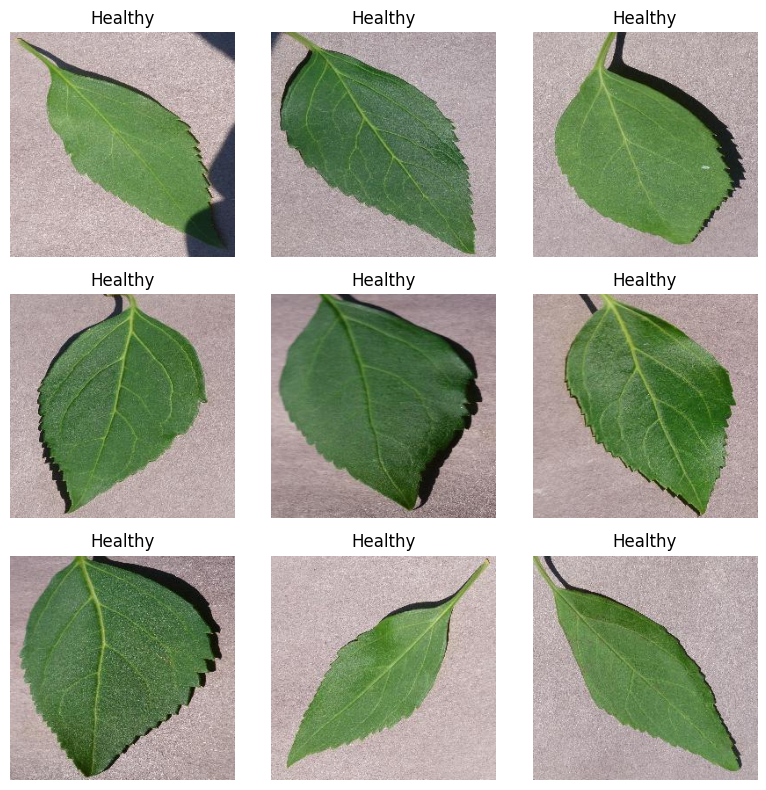

In [3]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from glob import glob
from PIL import Image
import random

# Directories for both classes
healthy_dir = '../data/cherry-leaves/healthy'
mildew_dir = '../data/cherry-leaves/powdery_mildew'

# Get image file paths
healthy_images = glob(os.path.join(healthy_dir, '*.JPG'))
mildew_images = glob(os.path.join(mildew_dir, '*.JPG'))

def show_images(class_name, n=9):
    if class_name == 'Healthy':
        imgs = random.sample(healthy_images, min(n, len(healthy_images)))
    else:
        imgs = random.sample(mildew_images, min(n, len(mildew_images)))
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for ax, img_path in zip(axes.flatten(), imgs):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(class_name)
    for ax in axes.flatten()[len(imgs):]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

dropdown = widgets.Dropdown(options=['Healthy', 'Powdery Mildew'], value='Healthy', description='Class:')
button = widgets.Button(description='Show New Samples')

output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output(wait=True)
        show_images(dropdown.value)

button.on_click(on_button_clicked)

display(widgets.HBox([dropdown, button]))
display(output)
show_images(dropdown.value)

## Class Distribution and Dataset Overview

Understanding the distribution of healthy and powdery mildew images is important for model development and business insights. The following cell visualizes the class balance in the dataset.

/tmp/ipykernel_9853/2350244832.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')


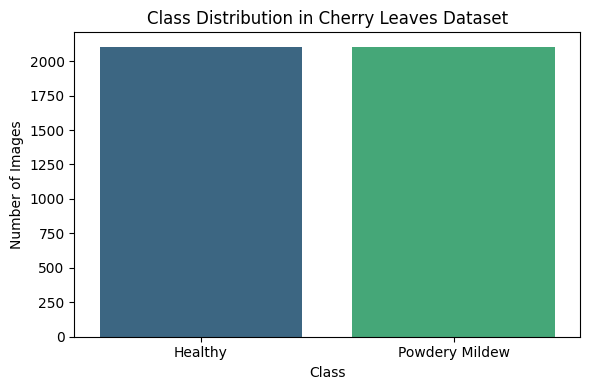

Summary Statistics:
Healthy: 2104 images
Powdery Mildew: 2104 images


In [4]:
# Plot class distribution and print summary statistics
class_counts = {'Healthy': len(healthy_images), 'Powdery Mildew': len(mildew_images)}
plt.figure(figsize=(6,4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')
plt.title('Class Distribution in Cherry Leaves Dataset')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.tight_layout()
plt.show()

print('Summary Statistics:')
for cls, count in class_counts.items():
    print(f'{cls}: {count} images')

Found 6144 images belonging to 2 classes.


/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


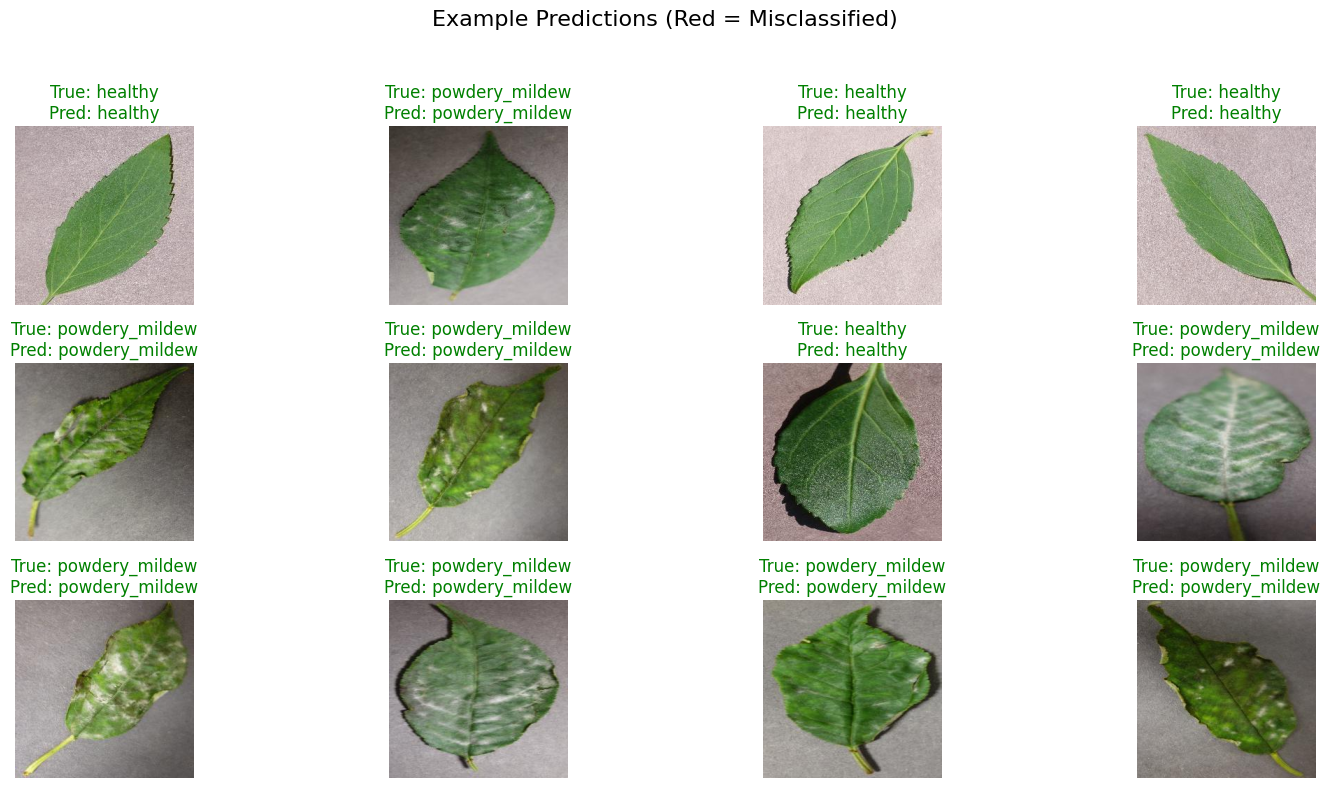

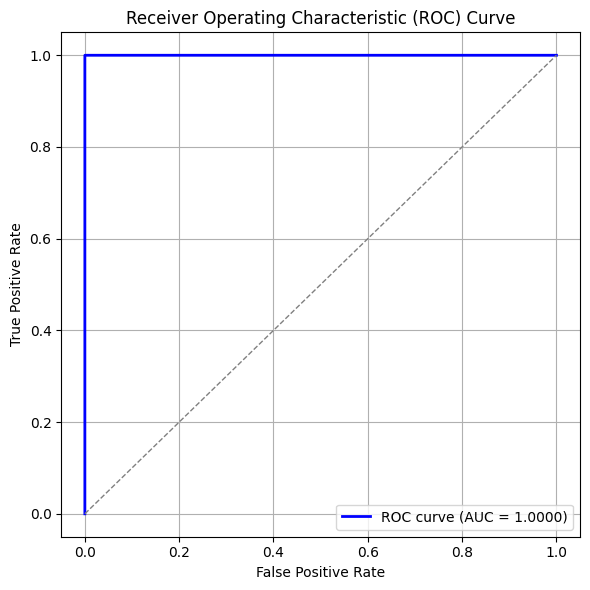

In [8]:
# --- Self-contained: Show example predictions and ROC curve without external notebook dependencies ---
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc

# Set up test data directory and parameters
split_base = '../data/split'
img_size = (224, 224)
batch_size = 18

# Prepare test generator
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_directory(
    directory=split_base,
    target_size=img_size,
    batch_size=batch_size,
    classes=['healthy', 'powdery_mildew'],
    class_mode='binary',
    shuffle=False,
    seed=42,
    color_mode='rgb',
)

# Load trained model
model_path = '../out/modeling/best_model.keras'
best_model = load_model(model_path)

# Get predictions and true labels
test_image_paths = test_generator.filepaths
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
y_pred_probs = best_model.predict(test_generator, verbose=0).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Show a grid of 12 random test images with predictions
n_show = 12
indices = np.random.choice(len(test_image_paths), n_show, replace=False)
plt.figure(figsize=(16, 8))
for i, idx in enumerate(indices):
    img = Image.open(test_image_paths[idx])
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    color = 'green' if y_true[idx] == y_pred[idx] else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
    plt.axis('off')
plt.suptitle('Example Predictions (Red = Misclassified)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Plot ROC curve and calculate AUC ---
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Mean and Variability of Images per Label

In this section, we calculate and visualize the average (mean) image and the variability (standard deviation) for each class. This helps in understanding the general characteristics and distinguishing features.

In [ ]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import os

def load_image_as_array(image_path, target_size=(100, 100)):
    img = image.load_img(image_path, target_size=target_size)
    return image.img_to_array(img) / 255.0

def get_class_arrays(data_dir, label, target_size=(100, 100), max_images=None):
    class_dir = os.path.join(data_dir, label)
    if not os.path.exists(class_dir):
        print(f"Directory not found: {class_dir}")
        return np.array([])
        
    filenames = os.listdir(class_dir)
    # Filter valid image extensions
    filenames = [f for f in filenames if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if max_images:
        filenames = filenames[:max_images]
    
    print(f"Loading {len(filenames)} images for {label}...")
    images = []
    
    for filename in tqdm(filenames):
        img_path = os.path.join(class_dir, filename)
        try:
            images.append(load_image_as_array(img_path, target_size))
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            
    return np.array(images)

# Configuration
target_size = (100, 100)
# Adjust path to data relative to notebook location
data_path = '../data/cherry-leaves' 
labels = ['healthy', 'powdery_mildew']

# Store means for difference calculation
means = {}

for label in labels:
    images_arr = get_class_arrays(data_path, label, target_size)
    if len(images_arr) == 0:
        continue
        
    mean_img = np.mean(images_arr, axis=0)
    std_img = np.std(images_arr, axis=0)
    means[label] = mean_img
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(mean_img)
    plt.title(f'Average {label} Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(std_img)
    plt.title(f'Variability {label}')
    plt.axis('off')
    
    save_path = f'../out/visualization/avg_var_{label}.png'
    # Ensure directory exists (it should from previous cells)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    print(f"Saved plot to {save_path}")
    plt.show()


## Difference between Average Images

Here we visualize the difference between the average 'Healthy' image and the average 'Powdery Mildew' image to highlight the distinct patterns.

In [ ]:

if 'healthy' in means and 'powdery_mildew' in means:
    mean_healthy = means['healthy']
    mean_mildew = means['powdery_mildew']
    
    difference = mean_mildew - mean_healthy
    
    plt.figure(figsize=(8, 8))
    plt.imshow(difference)
    plt.title('Difference: Powdery Mildew - Healthy')
    plt.axis('off')
    
    save_path_diff = '../out/visualization/difference_avg.png'
    plt.savefig(save_path_diff)
    print(f"Saved difference plot to {save_path_diff}")
    plt.show()
else:
    print("Means not available for difference calculation.")


## Hypothesis Validation

**Hypothesis:** Infected leaves have distinct white powdery patches that differentiate them from healthy leaves.

**Validation from Visualizations:**
*   **Average Image Analysis:** The average infected leaf image shows lighter/whitish potential patterns compared to the healthy average, though averaging spreads these out.
*   **Difference Analysis:** The difference between the average healthy and average infected leaf highlights the specific regions where the disease manifests. The high values in the difference plot correspond to the powdery mildew patches.
*   **Variability Analysis:** The variability images show where the features differ most among images of the same class.

Based on these visualizations, we observe clear differences in pixel intensity and distribution between the two classes, supporting the hypothesis that an ML model can learn to distinguish them.
